In [1]:
import matplotlib.pyplot as plt
import time
import warnings

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 8]
warnings.filterwarnings("ignore")

# Кластеризация

Как вы уже знаете, задачи машинного обучения сводятся к следующим типам:
* Обучение с учителем (регрессия, классификация)
* Обучение без учителя (кластеризация, понижение рамерности, поиск аномалий, ранжирование)
* Обучение с подкреплением

Передейдем к последнему классу задач Обучения без учителя - задача кластеризации.

## Задача кластеризации

- Нужно данные разбить на группы.
- Объекты в одной группе должны быть похожи между собой.
- Объекты разных групп должны отличаться.

Похожесть можно трактовать по разному, поэтому существуют различные методы кластеризации, отличающиеся метрикой или способом формирования метрики похожести.

- Алгоритмы, где в качестве метрики похожести используются метрики расстояния (К-Means, K-Means++, K-Median).
- Алгоритмы, основанные на различных статистических гипотезах (EM algorithm)
- Алгоритмы основанные на плотности выборки (распределения). За счет плотности расположения (распределения) выделяем кластеры.

In [2]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3,
            init="random",
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=42)

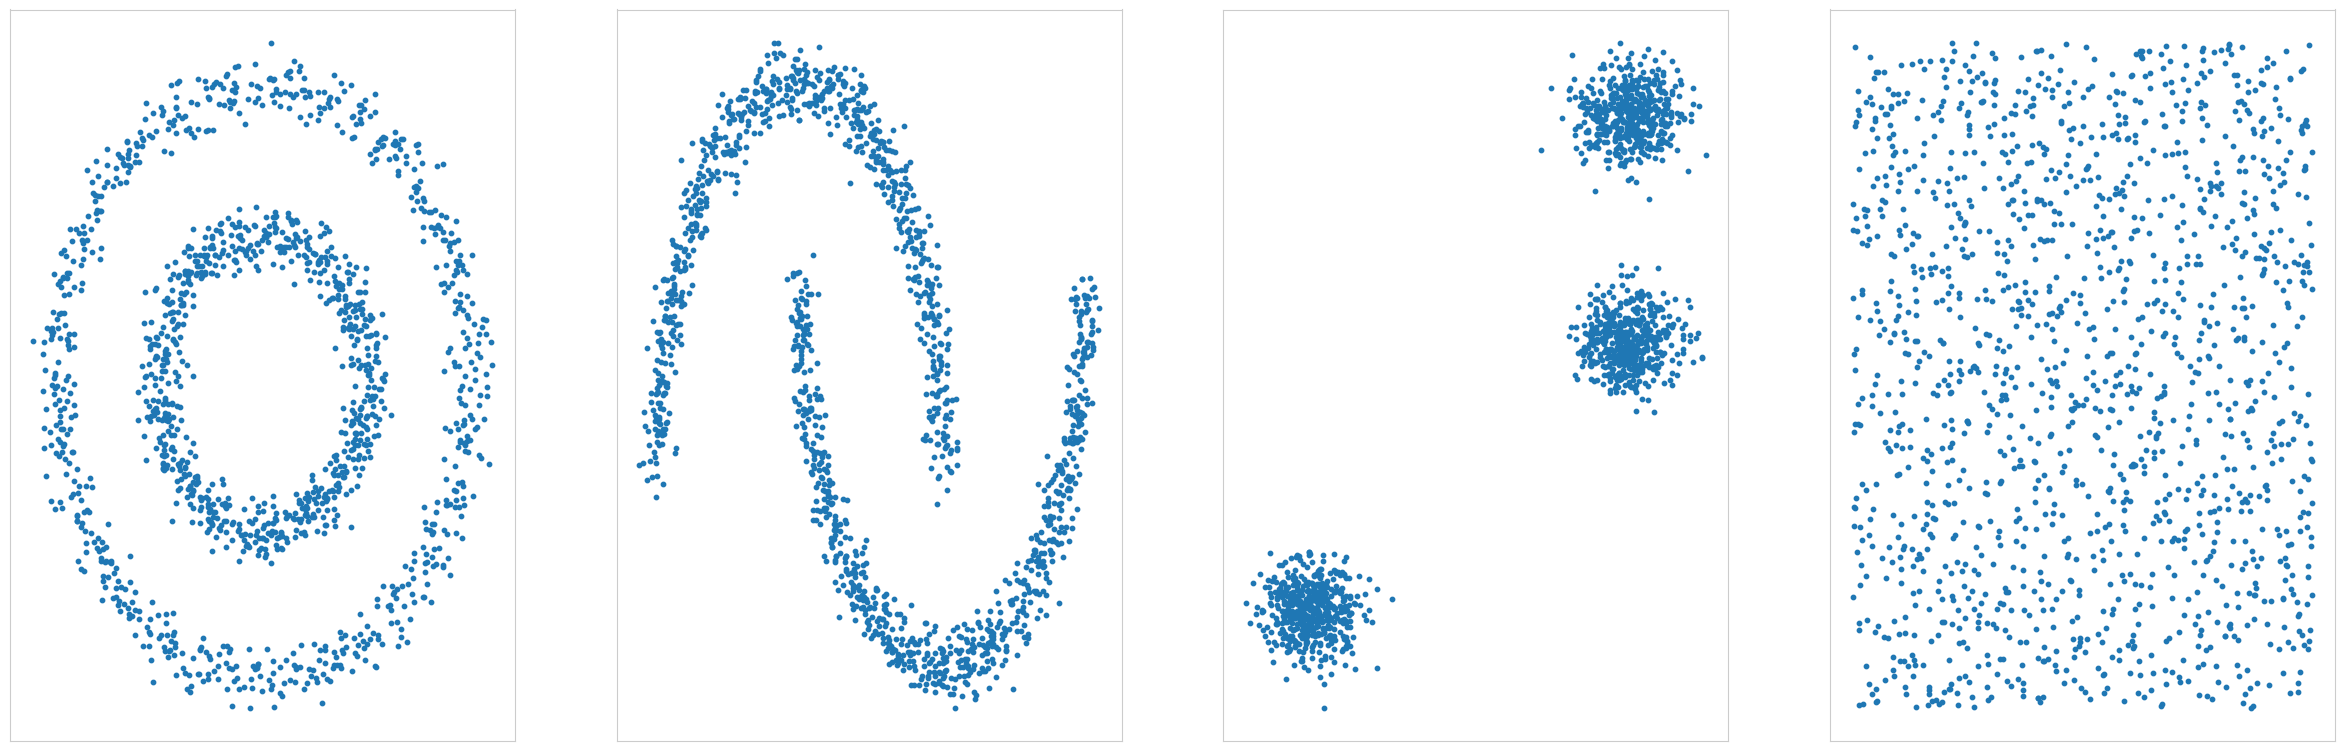

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
np.random.seed(42)

n_samples = 1500
# first datapoints
noisy_circles = datasets.make_circles(n_samples=n_samples,
                                      factor=.5,
                                      noise=.05)
# second datapoints
noisy_moons = datasets.make_moons(n_samples=n_samples,
                                  noise=.05)

# third datapoints
blobs = datasets.make_blobs(n_samples=n_samples,
                            random_state=8)


no_structure = np.random.rand(n_samples, 2), None

# Visualization
plt.figure(figsize=(30, 9.5))

data = [noisy_circles, noisy_moons, blobs, no_structure]

for i_dataset, dataset in enumerate(data):
    X, y = dataset

    X = StandardScaler().fit_transform(X)

    plt.subplot(1, 4, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10)
    # plt.xlim(-2, 2)
    # plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()

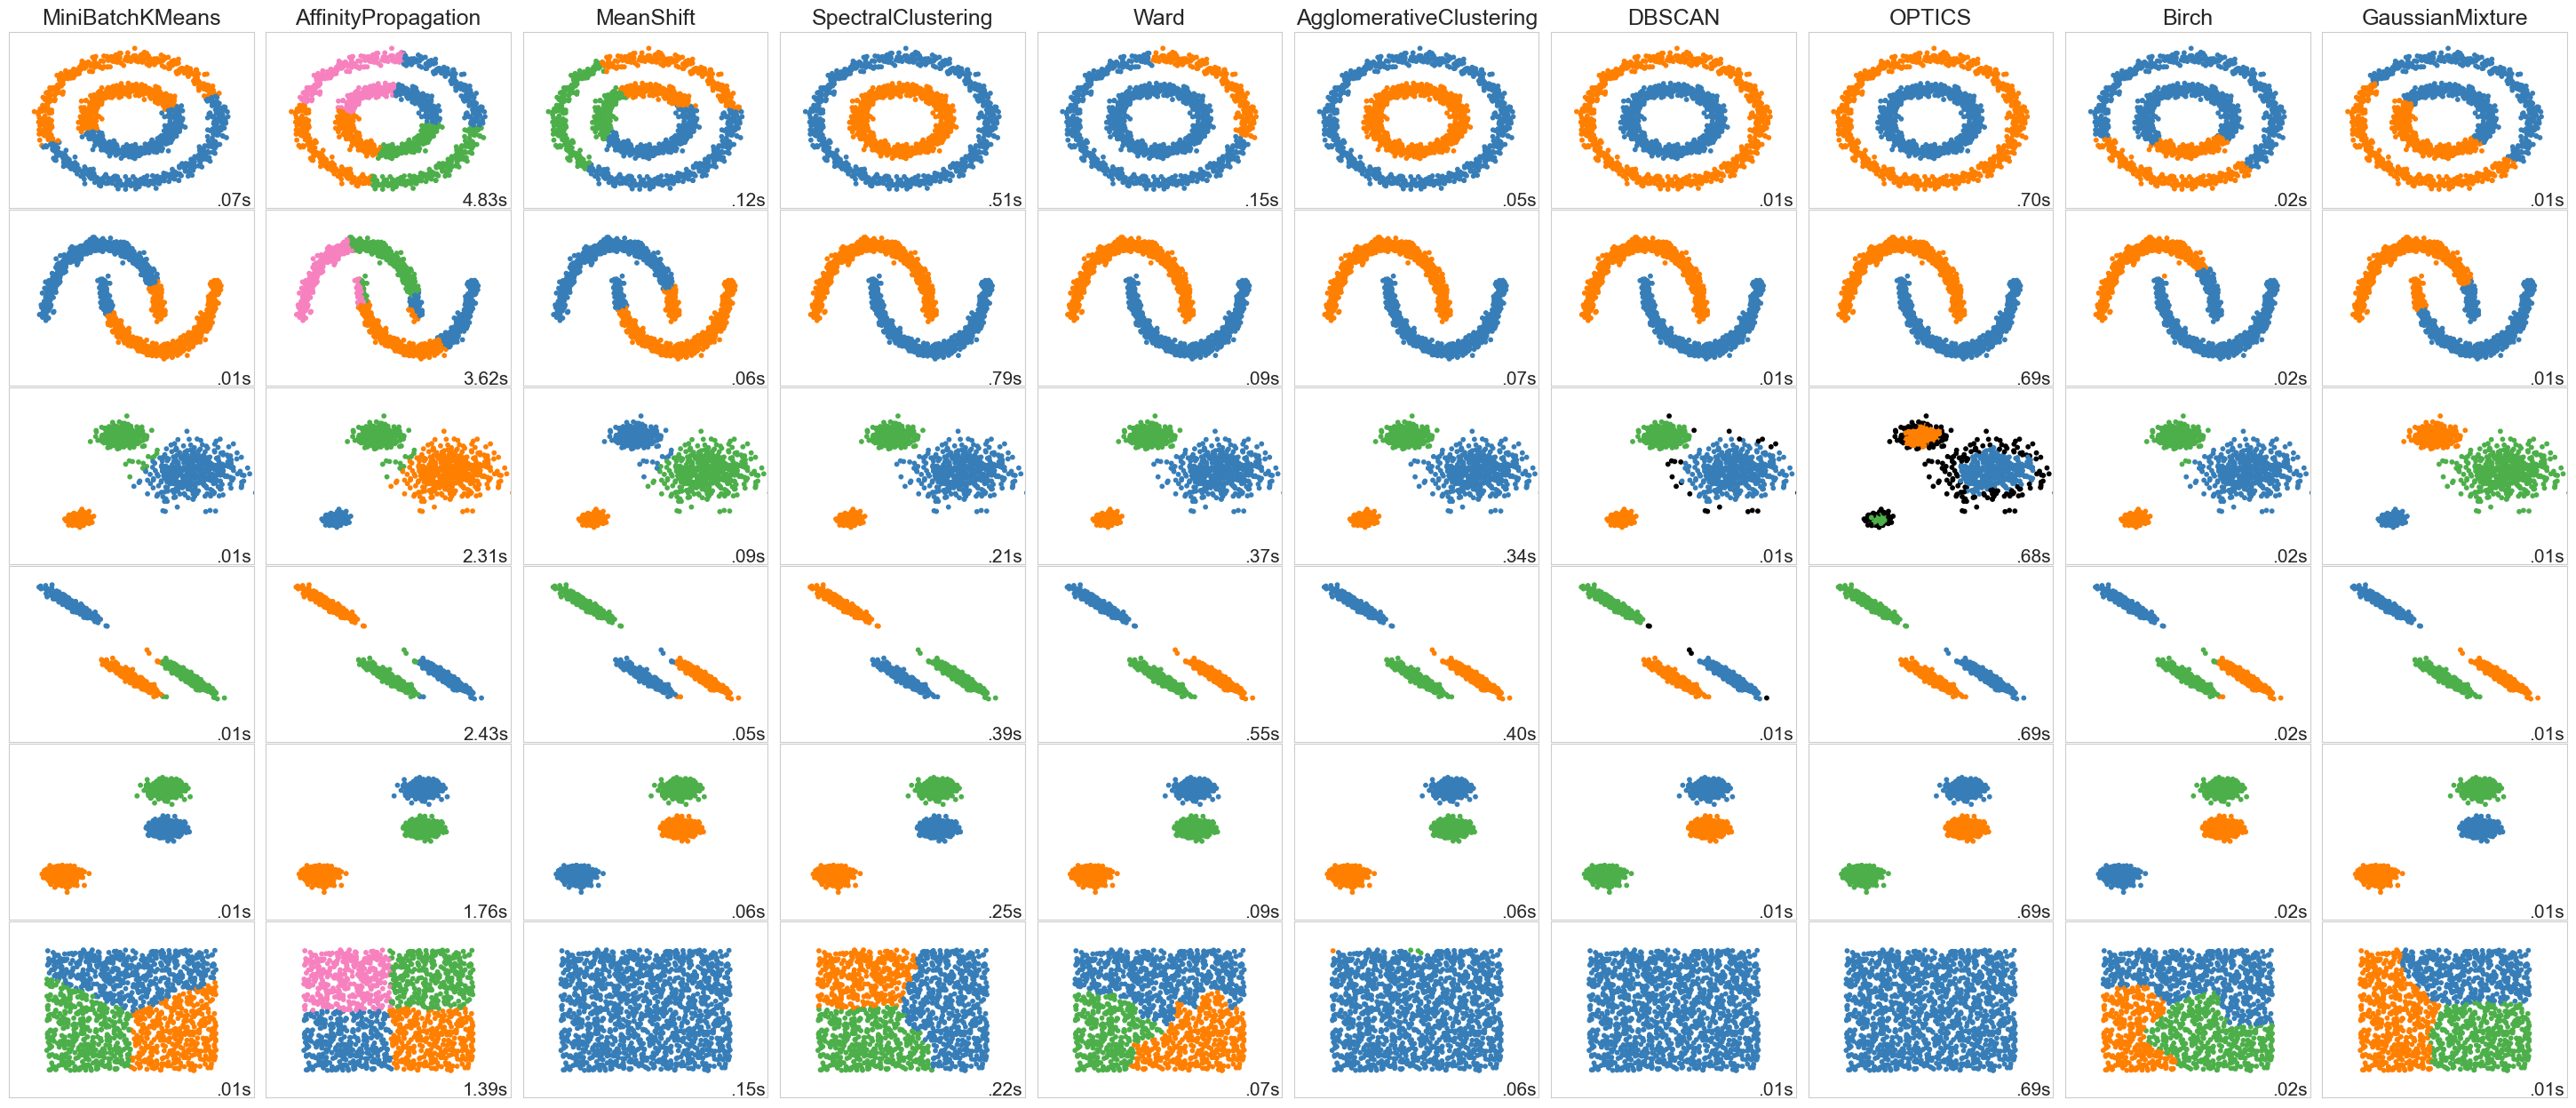

In [4]:
np.random.seed(42)

n_samples = 1500

noisy_circles = datasets.make_circles(n_samples=n_samples,
                                      factor=.5,
                                      noise=.05)

noisy_moons = datasets.make_moons(n_samples=n_samples,
                                  noise=.05)

blobs = datasets.make_blobs(n_samples=n_samples,
                            random_state=8)

no_structure = np.random.rand(n_samples, 2), None

random_state = 42


X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)

transformation = [[0.6, -0.6], [-0.4, 0.8]]

X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

plt.figure(figsize=(30, 12.5))
plt.subplots_adjust(left=.02,
                    right=.98,
                    bottom=.001,
                    top=.96,
                    wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77,
                     'preference': -240,
                     'quantile': .2,
                     'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75,
                   'preference': -220,
                   'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035,
              'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1,
             'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    X = StandardScaler().fit_transform(X)

    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T)

    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])

    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)

    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")

    dbscan = cluster.DBSCAN(eps=params['eps'])

    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])

    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])

    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)

    birch = cluster.Birch(n_clusters=params['n_clusters'])

    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int32)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))

        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

# Меры близости (как посчитать расстояние между объектами - наблюдениями из обучающей выборки?)

* Как определить похожие объекты?

* Необходимо ввести функцию расстояния (не обязательно метрику)

### Количественные признаки

$$ d(a, b) = \sum\limits_{i=1}^{D}(a_i - b_i)^2 \text{: euclidean distance} $$


5.0


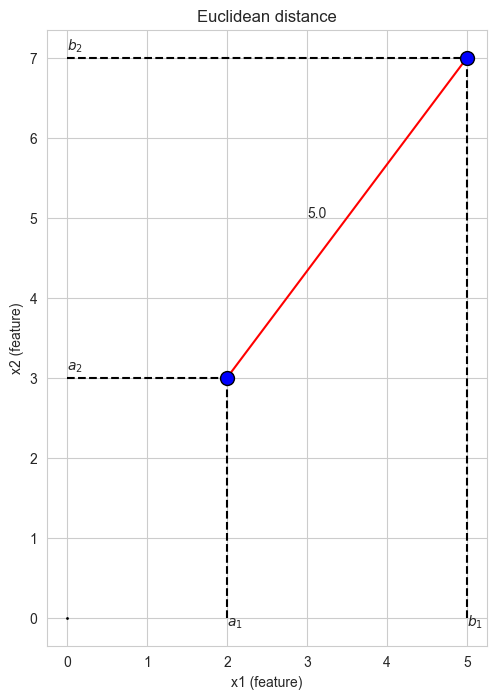

In [5]:
from scipy.spatial import distance

def draw_euclidean():
    X = np.array([
      [0,0],
      [2, 3],
      [5, 7]
    ])
    # Euclidean distance in scipy
    dist = distance.euclidean(X[1,:], X[2,:])

    print(dist)
    plt.scatter(X[0, 0], X[0, 1],  s=1, edgecolor='black')
    plt.scatter(X[1:, 0], X[1:, 1],zorder=2, c='blue', s=100, edgecolor='black')
    plt.title("Euclidean distance")
    plt.plot([2,2], [0,3], '--',zorder=1, c='black')
    plt.plot([5,5], [0,7], '--',zorder=1, c='black')
    plt.plot([0,2], [3,3], '--',zorder=1, c='black')
    plt.plot([0,5], [7,7], '--',zorder=1, c='black')
    plt.plot([2,5],[3,7], zorder=1, c='red')

    plt.text(0, 3.1, '$a_{2}$')
    plt.text(0, 7.1, '$b_{2}$')
    plt.text(2, -0.1, '$a_{1}$')
    plt.text(5, -0.1, '$b_{1}$')
    plt.text(3, 5, dist)

    plt.xlabel("x1 (feature)")
    plt.ylabel("x2 (feature)")
    plt.gca().set_aspect('equal', adjustable='box')
  
  
draw_euclidean()

$$ d(a, b) = \sum\limits_{i=1}^{D}|a_i - b_i| \text{: manhattan distance} $$

7


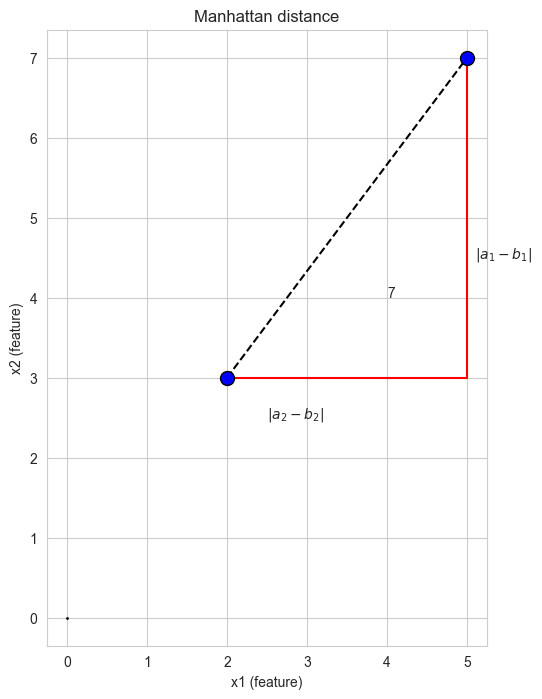

In [6]:
def draw_manhattan():
    X = np.array([
      [0,0],
      [2, 3],
      [5, 7]
    ])
    # Manhattan distaince in scipy
    dist = distance.cityblock(X[1,:], X[2,:])

    print(dist)
    plt.scatter(X[0, 0], X[0, 1],  s=1, edgecolor='black')
    plt.scatter(X[1:, 0], X[1:, 1],zorder=2, c='blue', s=100, edgecolor='black')
    plt.title("Manhattan distance")
    plt.plot([2,5], [3,3], zorder=1, c='red')
    plt.plot([5,5], [3,7], zorder=1, c='red')
    plt.plot([2,5],[3,7],'--', zorder=1, c='black')
    plt.text(2.5,2.5, '$|a_{2}-b_{2}|$')
    plt.text(5.1, 4.5, '$|a_{1}-b_{1}|$')
    plt.text(4, 4, dist)
    plt.xlabel("x1 (feature)")
    plt.ylabel("x2 (feature)")
    plt.gca().set_aspect('equal', adjustable='box')  

    
draw_manhattan()

$$ d(a, b) = \frac{\langle a,b \rangle}{||a||\cdot||b||} \text{: cosine similarity, где} $$
$$||a|| \text{ и } ||b|| \text{ - длины векторов a и b  }$$ 

$$\langle a,b \rangle \text{ - скалярное произведение векторов a и b  }$$ 



0.2697285864811044


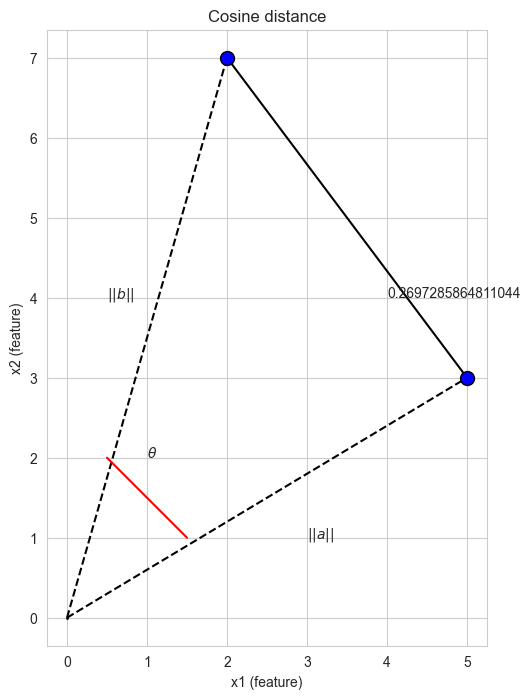

In [7]:
from matplotlib.patches import Arc
def draw_cosine():
    X = np.array([
      [0,0],
      [2, 7],
      [5, 3]
    ])
    # Cosine distance in scipy
    dist = distance.cosine(X[1,:], X[2,:])

    print(dist)
    plt.scatter(X[0, 0], X[0, 1],  s=1, edgecolor='black')
    plt.scatter(X[1:, 0], X[1:, 1],zorder=2, c='blue', s=100, edgecolor='black')
    plt.title("Cosine distance")
    plt.plot([0,2], [0,7],'--', zorder=1, c='black')
    plt.plot([0,5], [0,3],'--', zorder=1, c='black')
    plt.plot([2,5],[7,3], zorder=1, c='black')
    plt.text(4, 4, dist)
    plt.text(1, 2, '$\\theta$')
    plt.text(3, 1, '$||a||$')
    plt.text(0.5, 4, '$||b||$')
    plt.plot([0.5,1.5],[2,1], zorder=1, c='red')

    plt.xlabel("x1 (feature)")
    plt.ylabel("x2 (feature)")
    plt.gca().set_aspect('equal', adjustable='box')
  
  
draw_cosine()

### Близость на бинарных векторах

* Пусть объект описывается набором бинарных признаков 
    * A: `(1, 0, 1, 0)`
    * B:     `(1, 1, 0, 1)`
* Расстояние Хэмминга -  Hamming distance
    * Количество (доля) несовпавших значений
    
    $$d(\text{A},\text{B}) = 3 $$


In [9]:
def calc_hamming():
    A = np.array([1, 0, 1, 0])
    B = np.array([1, 1, 0, 1])
    # Hamming distance in scipy
    dist = distance.hamming(A,B)
    print(dist)

    
calc_hamming()

0.75


### Близость на множествах
* Пусть объект описывается набором категорий, слов, тегов
    * A: {a, b, c, d}
    * B: {a, e, f, c, g}
* Расстояние Жаккара - Jaccard distance:
$$d(a,b) = 1 - \frac{|a \cap b|}{|a \cup b|}$$

$$d(a,b) = 1 - \frac{2}{7} = \frac{5}{7} $$

In [10]:
def calc_jaccard():
    A = np.array([1, 1, 1, 1, 0, 0, 0])
    B = np.array([1, 0, 1, 0, 1, 1, 1])
    # Jaccard distance in scipy
    dist = distance.jaccard(A,B)
    print(dist)
calc_jaccard()

0.7142857142857143


### Расстояние на строках
* Расстояние Левенштейна

Количество операций вставки $(I)$, удаления $(D)$ и замены $(R)$, которое необходимо сделать, чтобы получить из строки $S_1$ строку $S_2$.

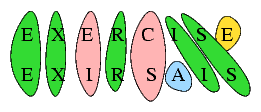

# Типы алгоритмов кластеризации

* soft clustering - работает с вероятностями объектов.
* hard clustering - работает с абсолютными значениями.

# Алгоритм K-Means
* Выбрать количество кластеров k, которое нам кажется оптимальным для наших данных.
* Выбрать случайным образом k точек (центроидов)
* Для каждой точки определить, к какому центроиду она ближе.
* Переместить каждый центроид в центр выборки, которую мы отнесли к этому центроиду.
* Повторять последние два шага или $n\_iter$ число раз, или когда кластеры сойдутся.

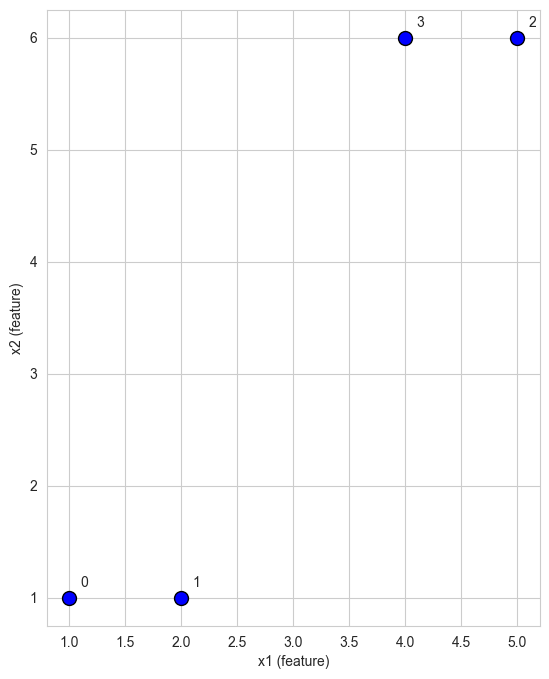

In [11]:
X = np.array([
    [1, 1],
    [2, 1],
    [5, 6],
    [4, 6]
])

plt.scatter(X[:, 0], X[:, 1], c='blue', s=100, edgecolor='black')
for idx, row in enumerate(X):
    plt.text(row[0] + 0.1, row[1] + 0.1, idx)
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

Зададим $k$ - количество кластеров. Это параметр алгоритма. Будем пользоваться евклидовым расстоянием для наглядности.

1. Случайным образом выберем $k$ точек. Можно выбирать точки из выборки, можно взять случайные точки на плоскости в том же диапазоне.

In [12]:
centroids = np.array([[1, 5], [5, 2]])

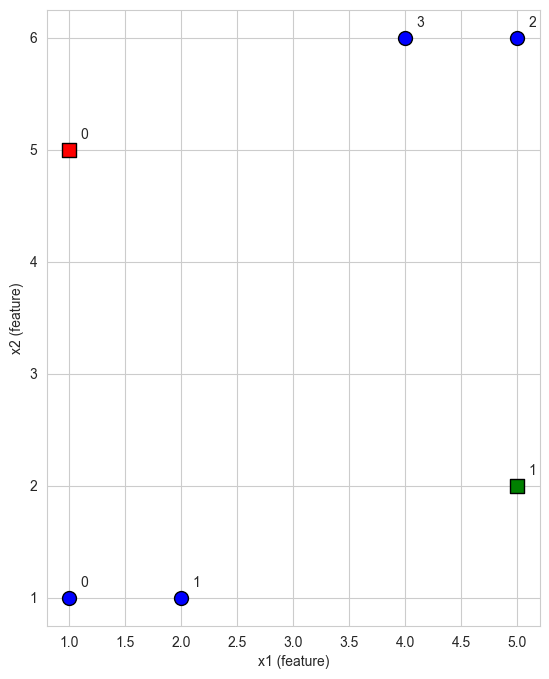

In [13]:
plt.scatter(X[:, 0], X[:, 1], c='blue', s=100, edgecolor='black')
for idx, row in enumerate(X):
    plt.text(row[0] + 0.1, row[1] + 0.1, idx)
for idx, row in enumerate(centroids):
    plt.text(row[0] + 0.1, row[1] + 0.1, idx)
plt.scatter(centroids[0, 0], centroids[0, 1], c='red', s=100, edgecolor='black', marker='s')
plt.scatter(centroids[1, 0], centroids[1, 1], c='green', s=100, edgecolor='black', marker='s')
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

  2 . каждой точке проставим метку кластера - ближайший к ней центроид

In [14]:
from scipy.spatial.distance import cdist
labels = cdist(X, centroids).argmin(axis=1)
print(labels)

[0 1 1 0]


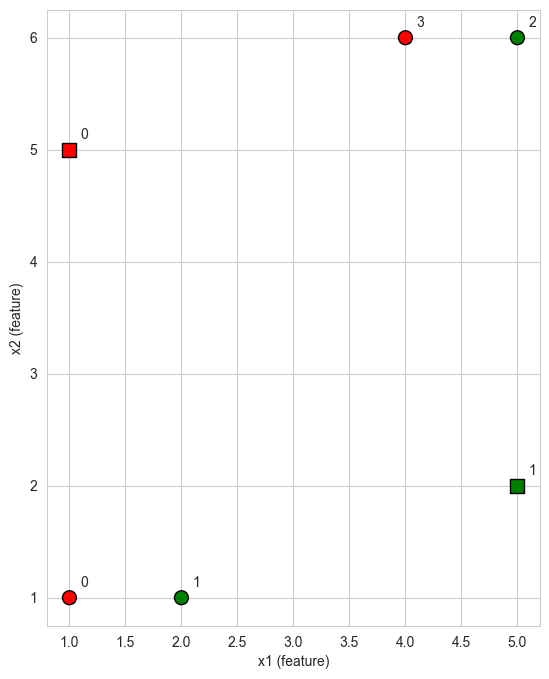

In [15]:
plt.scatter(X[:, 0], X[:, 1], c=['green' if l else 'red' for l in labels], s=100, edgecolor='black')
for idx, row in enumerate(X):
    plt.text(row[0] + 0.1, row[1] + 0.1, idx)
for idx, row in enumerate(centroids):
    plt.text(row[0] + 0.1, row[1] + 0.1, idx)
plt.scatter(centroids[0, 0], centroids[0, 1], c='red', s=100, edgecolor='black', marker='s')
plt.scatter(centroids[1, 0], centroids[1, 1], c='green', s=100, edgecolor='black', marker='s')
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

3 . Обновим координаты центров кластеров (центроидов).
Для этого возьмем точки, отнесенные к центроиду на предыдущем шаге, и посчитаем среднее по каждой координате (центр масс)

In [16]:
centroids =  np.array([X[labels == 0].mean(axis=0), X[labels == 1].mean(axis=0)])

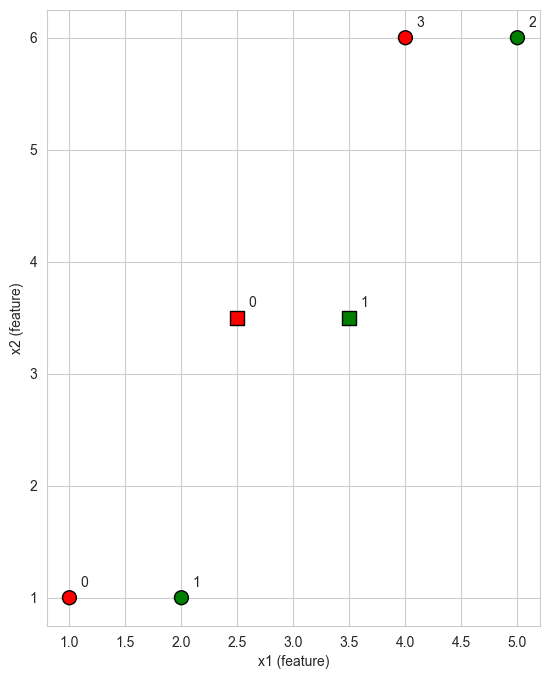

In [17]:
plt.scatter(X[:, 0], X[:, 1], c=['green' if l else 'red' for l in labels], s=100, edgecolor='black')
for idx, row in enumerate(X):
    plt.text(row[0] + 0.1, row[1] + 0.1, idx)
for idx, row in enumerate(centroids):
    plt.text(row[0] + 0.1, row[1] + 0.1, idx)
plt.scatter(centroids[0, 0], centroids[0, 1], c='red', s=100, edgecolor='black', marker='s')
plt.scatter(centroids[1, 0], centroids[1, 1], c='green', s=100, edgecolor='black', marker='s')
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

4 . Будем повторять шаги 2 и 3, пока не достигнем сходимости (пока центры не перестанут изменяться значительно)

In [18]:
from scipy.spatial.distance import cdist
labels = cdist(X, centroids).argmin(axis=1)
print(labels)

[0 0 1 1]


In [19]:
centroids =  np.array([X[labels == 0].mean(axis=0), X[labels == 1].mean(axis=0)])

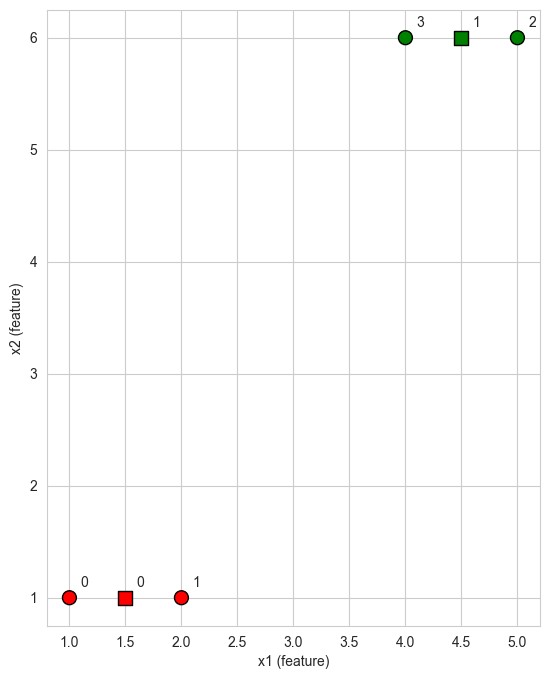

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=['green' if l else 'red' for l in labels], s=100, edgecolor='black')
for idx, row in enumerate(X):
    plt.text(row[0] + 0.1, row[1] + 0.1, idx)
for idx, row in enumerate(centroids):
    plt.text(row[0] + 0.1, row[1] + 0.1, idx)
plt.scatter(centroids[0, 0], centroids[0, 1], c='red', s=100, edgecolor='black', marker='s')
plt.scatter(centroids[1, 0], centroids[1, 1], c='green', s=100, edgecolor='black', marker='s')
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.gca().set_aspect('equal', adjustable='box')

In [21]:
from scipy.spatial.distance import cdist
labels = cdist(X, centroids).argmin(axis=1)
print(labels)

[0 0 1 1]


## Подбор $k$ - метод локтя

Выбрать критерий качества кластеризации и построить его значение для $K = 1, 2, . . .$

Text(0, 0.5, 'x2 (feature)')

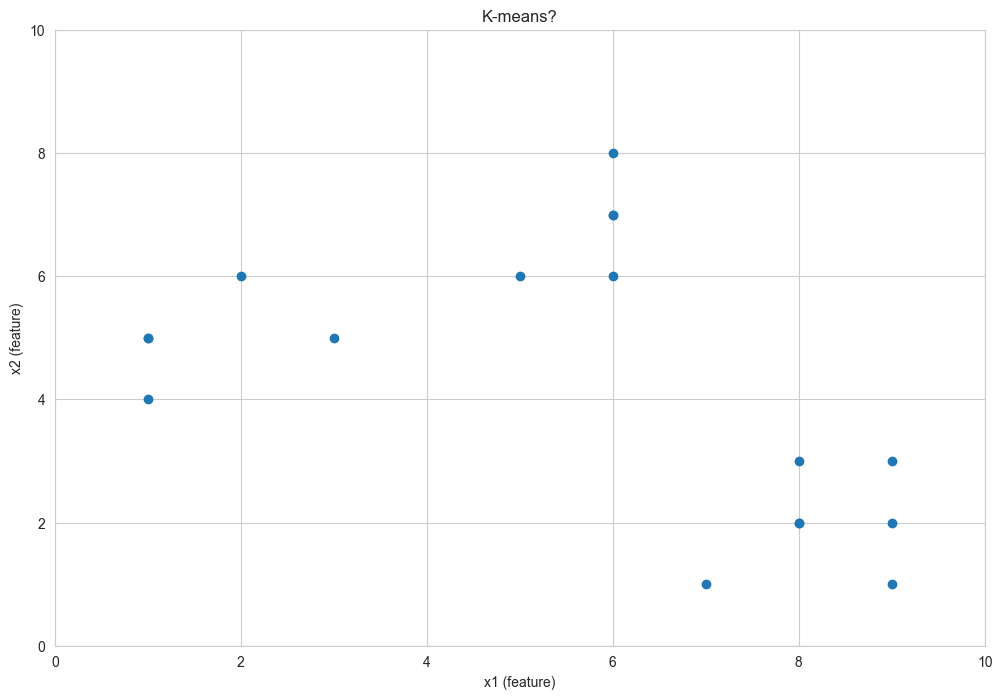

In [22]:
from sklearn.cluster import KMeans
from sklearn import metrics

X = np.array([
    [3, 1, 1, 2, 1, 6, 6, 6, 5, 6, 7, 8, 9, 8, 9, 9, 8],
    [5, 4, 5, 6, 5, 8, 6, 7, 6, 7, 1, 2, 1, 2, 3, 2, 3]
]).T

plt.scatter(X[:,0], X[:,1])
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.title("K-means?")
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")

## Критерии качества
* инерция - средняя сумма квадратов расстояния до центроида
* средний диаметр кластера
* силуэт

Пусть дана кластеризация в $K$ кластеров, и объект $i$ попал в $C_k$  
$a(i)$ -- среднее расстояние от $i$ объекта до объектов из $C_k$  
$b(i) = min_{j \neq k} b_j(i)$,  где $b_j(i)$ -- среднее расстояние от $i$ объекта до объектов из $C_j$

$$silhouette(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$$
Средний silhouette для всех точек из $\mathbf{X}$ является критерием качества кластеризации.

Показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. 

Принимает значения $[−1,1]$. 
$-1$ - плохая (разрозненная) кластеризация.  
$0$ - кластеры пересекаются и накладываются друг на друга  
$1$ - "плотные" четко выделенные кластера  
Чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.  



Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

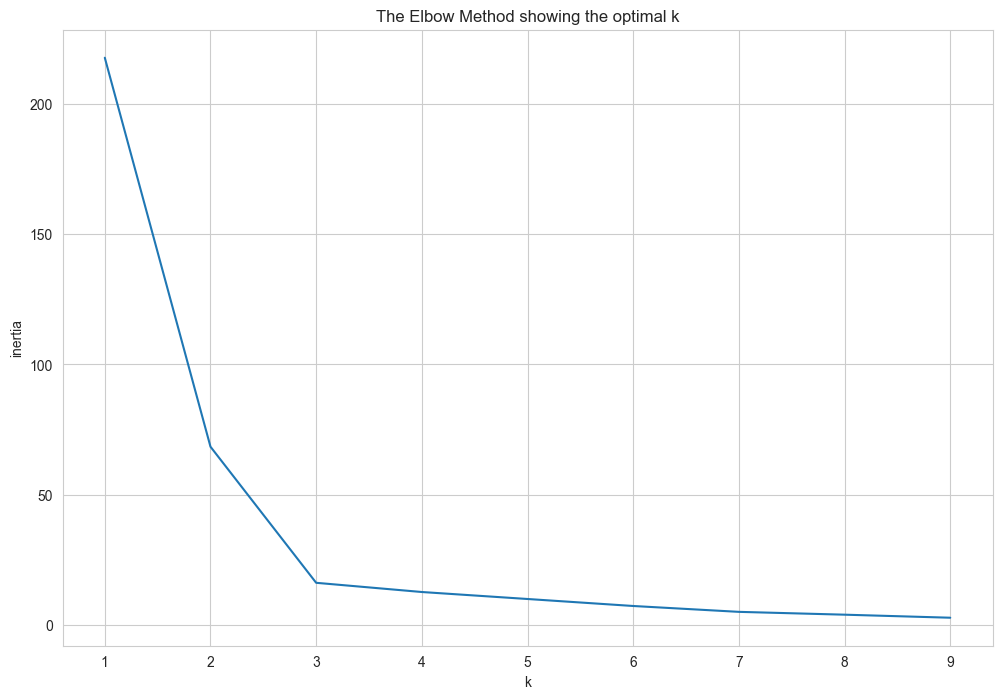

In [23]:
inertia = []
k = range(1, 10)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(X)
    km.fit(X)
    inertia.append(km.inertia_)
 
plt.plot(k, inertia)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('The Elbow Method showing the optimal k')

[0.6113424368705715, 0.7122079383287169, 0.6389948643127632, 0.5730476047724169, 0.4421681922609326, 0.3883319447429514, 0.37560176813183055, 0.34011594848992555]


Text(0.5, 1.0, 'Method showing the optimal k using silhoutte scores')

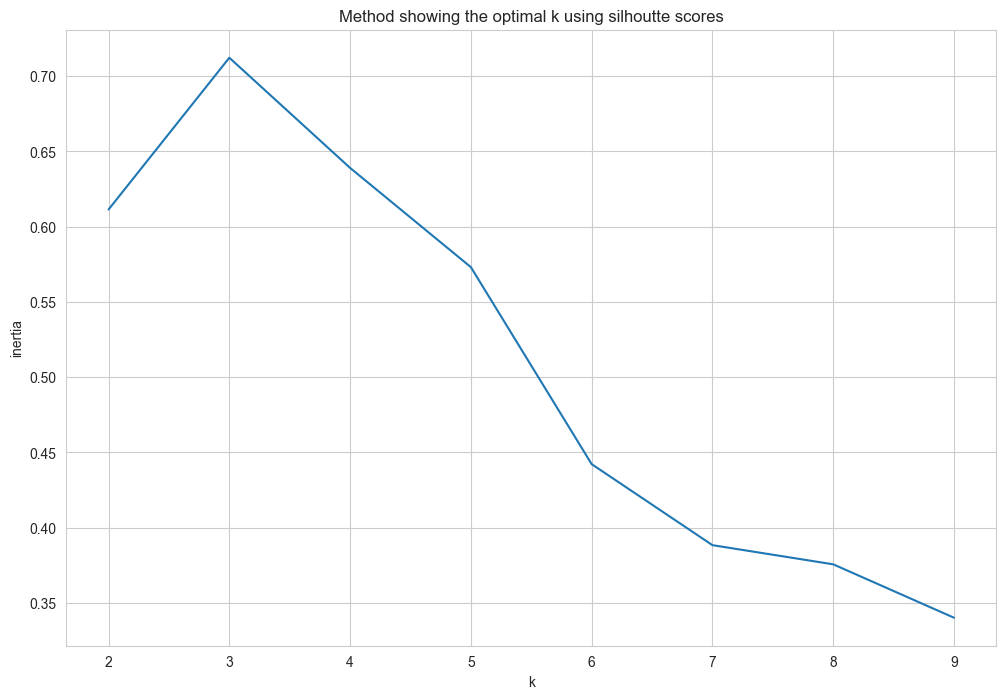

In [45]:
from sklearn.metrics import silhouette_score
inertia = []
k = range(2, 10)

for k_i in k:
    km = KMeans(n_clusters=k_i).fit(X)
    km.fit(X)
    inertia.append(silhouette_score(X, km.labels_))

print(inertia)
    
plt.plot(k, inertia)
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Method showing the optimal k using silhoutte scores')

## Модификации
* mini-batch k-means
* k-means++
* online k-means

# Иерархическая кластеризация

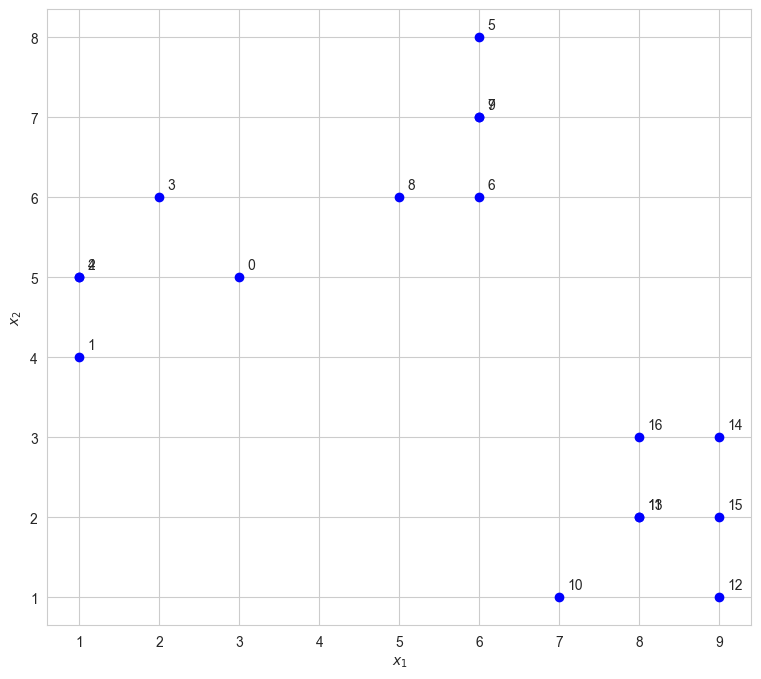

In [47]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X, method='centroid', metric='euclidean')

plt.scatter(X[:,0], X[:,1], c='blue')
for idx, row in enumerate(X):
    plt.text(row[0] + 0.1, row[1] + 0.1, idx)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.gca().set_aspect('equal', adjustable='box')

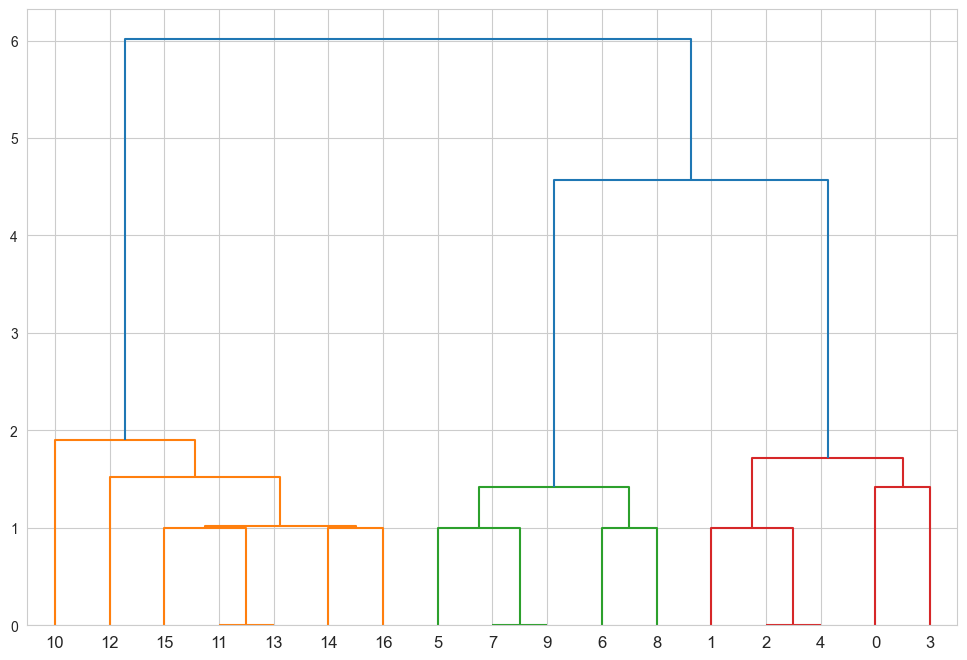

In [48]:
fig, ax = plt.subplots(1, 1)
dend = dendrogram(Z, ax=ax, truncate_mode='lastp') 

### Виды расстояний между кластерами

**single-linkage**

$$d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}'\|$$

**complete-linkage**

$$d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \|$$

**average linkage**

$$d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \|$$


**centroid linkage**
$$d_{mean}(C_i, C_j) = \|\mathbf{m}_i -\mathbf{m}_j \| $$


## EM-кластеризация

Основана на вероятностной природе распределения наших данных. В классическом подходе мы используем нормальное распределение.

Простыми словами что мы предпринимаем в ЕМ алгоритме:
Мы пытаемся найти оценку максимального правдоподобия параметров вероятностной модели. Алгоритм состоит из 2-х шагов:
1. Шаг Е: вычисляем ожидаемое значение функции правдоподобия.
2. Шаг М: вычисляем оценку максимального правдопободия.

## Гипотеза о вероятностной природе данных
Выборка $X^l$ случайна, независима, из смеси распределений 
$$p(x) = \sum_y w_y p_y(x)$$
$$\sum_y w_y = 1$$

## Гипотеза о пространстве объектов и форме кластеров

$$X = R^n$$
$$ p_y(x) = (2 * \pi)^{\frac{-n}{2}} (\sigma_{y1} ... \sigma_{yn}) ^ {-1} exp(\frac{-1}{2}\rho_y^2(x, \mu_y))$$

Центры кластеров: $$\mu_y = (\mu_{y1}, ..., \mu_{yn})$$
Диагональная матрица ковариаций: $$\Sigma_y = diag(\sigma_{y1}, ..., \sigma_{yn})$$

$$\rho_y^2(x, x') = \sum_{j}\sigma_{yj}^{-2} |f_j(x) - f_j(x')|$$

EM-алгоритм:
1. задать начальное приближение для $w_y, \mu_y, \Sigma_y$
2. E-шаг:
$$ g_{iy} = P(x | x_i) = \frac{w_y p_y(x)}{\sum_z {w_z p_z(x_i)}}$$
3. M-шаг:
$$w_y = \frac{1}{l}\sum_i g_{iy}$$
$$\mu_{yj} = \frac{1}{lw_y} \sum_i g_iy f_j(x_i)$$
$$\sigma = ....$$
$$ y_i = \arg \max_y (g_{iy}) $$

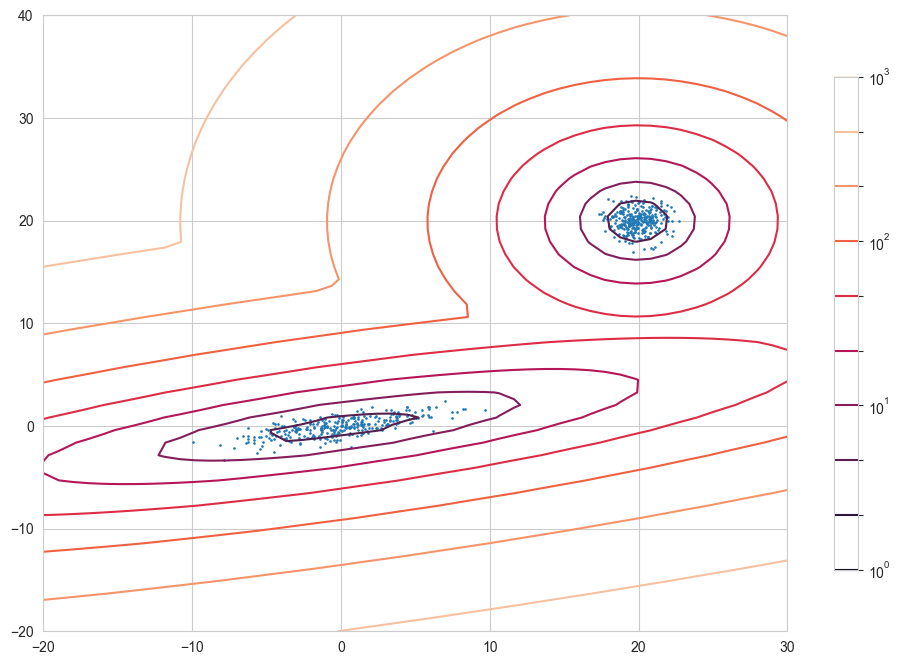

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

np.random.seed(0)

shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

X_train = np.vstack([shifted_gaussian, stretched_gaussian])

clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.axis('tight')
plt.show()

# DBScan

[Визуализация алгоритма](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

* Кластеризация, основанная на плотности объектов
* Кластеры – участки высокой плотности, разделенные участками низкой
плотности

#### Определения

**Плотность**  
Количество объектов внутри сферы заданного радиуса $\varepsilon$

**Core-объект**  
Объект $\mathbf{x}$ является core-объектом, если плотность вокруг него больше $min\_pts$

**Граничный-объект**  
Объект $\mathbf{x}$ является граничным-объектом, если плотность вокруг него меньше $min\_pts$, но он находится внутри сферы заданного радиуса вместе с хотя бы одним core-объектом

**Шум**  
Объект $\mathbf{x}$ является шумом, если он не является ни core-объектом, ни граничным объектом


#### Параметры алгоритма
$min\_pts$, $\varepsilon$

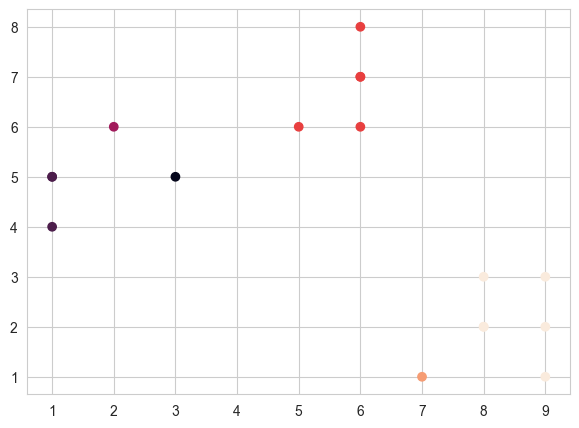

In [34]:
from sklearn.cluster import DBSCAN

X = np.array([
    [3, 1, 1, 2, 1, 6, 6, 6, 5, 6, 7, 8, 9, 8, 9, 9, 8],
    [5, 4, 5, 6, 5, 8, 6, 7, 6, 7, 1, 2, 1, 2, 3, 2, 3]
]).T


def dbscan_demo(eps=1, min_pts=1):
    dbscan = DBSCAN(eps=eps, min_samples=min_pts).fit(X)
    labels = dbscan.labels_
    plt.figure(figsize=(7, 5))
    plt.scatter(X[:, 0], X[:, 1], c=labels)

    
dbscan_demo()



```
function dbscan(X, eps, min_pts):
	initialize NV = X 
	for x in NV:
		remove(NV, x) 
		nbr = neighbours(x, eps) 
		if nbr.size < min_pts:
			mark_as_noise(x)
		else:
			C = new_cluster()
			expand_cluster(x, nbr, C, eps, min_pts, NV)
			yield C
```


```


function expand_cluster(x, nbr, C, eps, min_pts, NV):
	add(x, C)
	for x1 in nbr:
		if x1 in NV: 
			remove(NV, x1) 
			nbr1 = neighbours(x1, eps)
			if nbr1.size >= min_pts:
				# join sets of neighbours
				merge(nbr, nbr_1)
		if x1 not in any cluster:
			add(x1, C)
```



[Подбор параметров в DBScan](http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)


**Сложность**: $O(n^2)$ или $O(n \log n)$ ($R^*Tree$) \\
**Память**: $O(n)$ или $O(n^2)$

* не требует $K$
* кластеры произвольной формы
* учитывает выбросы
* Не вполне детерминированный
* Не работает при разных плотностях кластеров

# Отладка алгоритма
Используются данные, для которых кластера известны заранее. Далее можно оценить метрику.

Пусть дана обучающая выборка, для которой правильная кластеризация $C$ известна. С помощью выбранного алгоритма получена кластеризация $K$. Проверить, насколько $K$ совпадает с $C$.

**Adjusted Rand Index**
$a$ -- кол-во пар объектов, попавших в один кластер и в $C$, и в $K$   
$b$ -- кол-во пар объектов, попавших в разные кластеры и в $C$, и в $K$  

$$RI = \frac{a+b}{C^N_2}, \quad ARI = \frac{RI - E_{rdm}[RI]}{\max(RI) - E_{rdm}[RI]}$$


**Mutual Information**
$$MI = \sum_{c \in C} \sum_{k \in K} p(c, k) \log \frac{p(c, k)}{p(k)p(c)}$$


Text(0, 0.5, 'x2 (feature)')

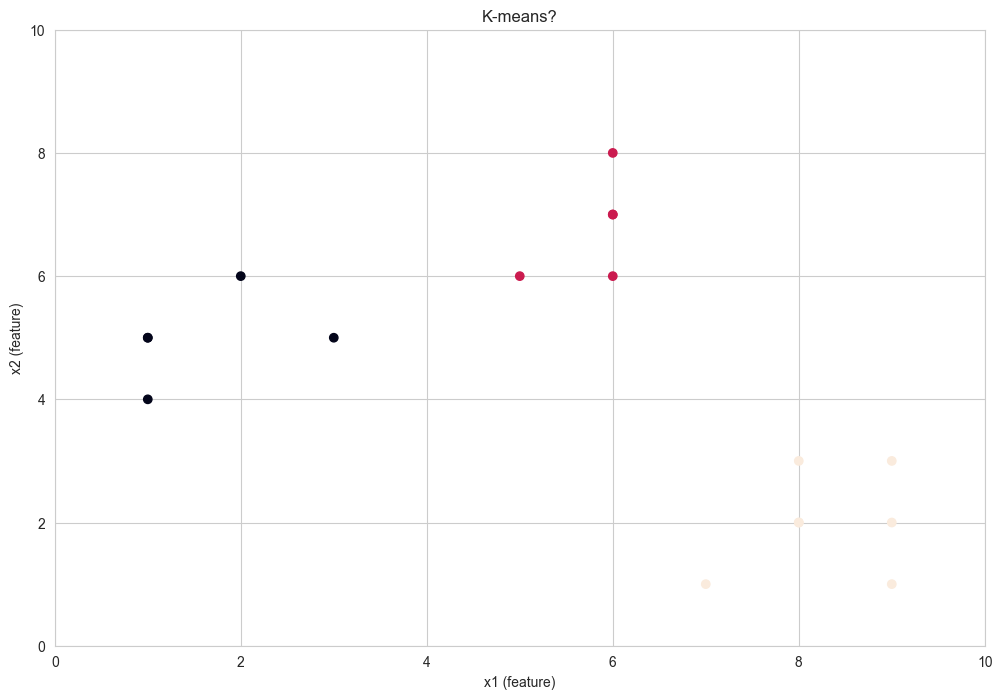

In [35]:
from sklearn.cluster import KMeans
from sklearn import metrics

X = np.array([
    [3, 1, 1, 2, 1, 6, 6, 6, 5, 6, 7, 8, 9, 8, 9, 9, 8],
    [5, 4, 5, 6, 5, 8, 6, 7, 6, 7, 1, 2, 1, 2, 3, 2, 3]
]).T
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2])

plt.scatter(X[:,0], X[:,1], c=y)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.title("K-means?")
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")

In [36]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

Text(0, 0.5, 'x2 (feature)')

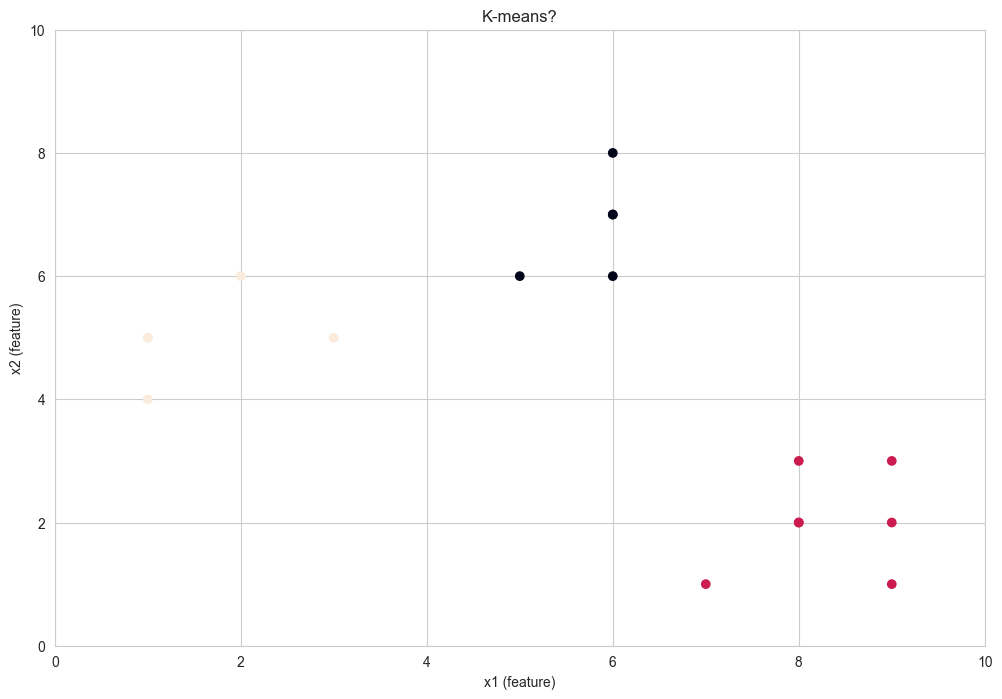

In [37]:
km = KMeans(n_clusters=3).fit(X)
km.fit(X)
plt.scatter(X[:,0], X[:,1], c=km.labels_)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.title("K-means?")
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")

In [38]:
adjusted_rand_score(km.labels_, y)
adjusted_mutual_info_score(km.labels_, y)

1.0

0.0
0.0


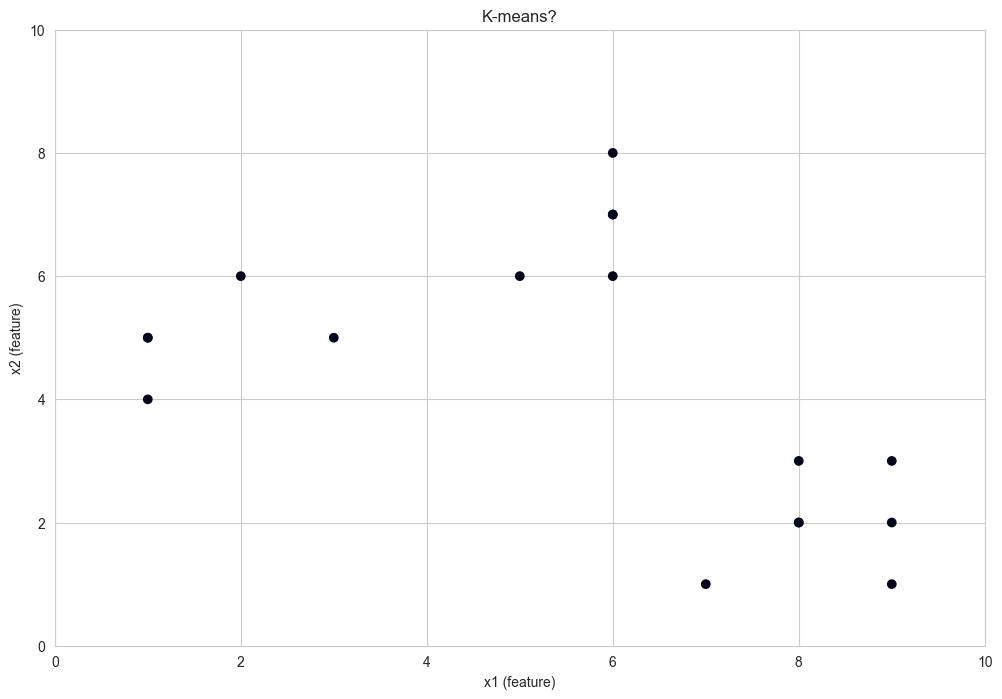

In [39]:
km = KMeans(n_clusters=1).fit(X)
km.fit(X)
plt.scatter(X[:,0], X[:,1], c=km.labels_)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.title("K-means?")
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
print(adjusted_rand_score(km.labels_, y))
print(adjusted_mutual_info_score(km.labels_, y))

0.2820851204223029
0.42915199082426875


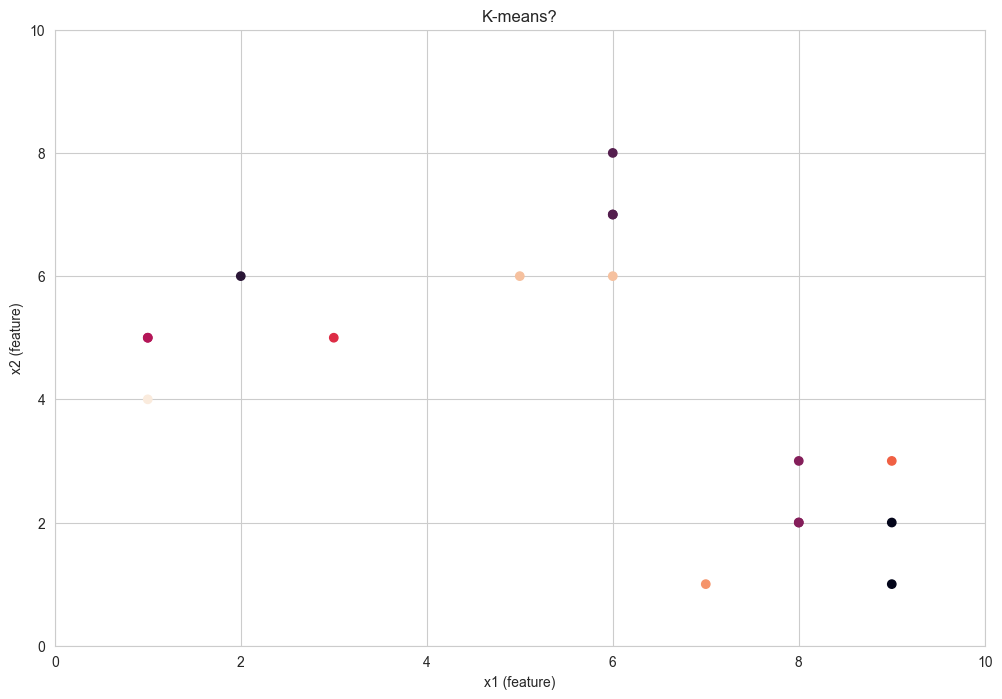

In [40]:
km = KMeans(n_clusters=10).fit(X)
km.fit(X)
plt.scatter(X[:,0], X[:,1], c=km.labels_)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.title("K-means?")
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
print(adjusted_rand_score(km.labels_, y))
print(adjusted_mutual_info_score(km.labels_, y))

-0.050482758620689655
-0.021933868292168857


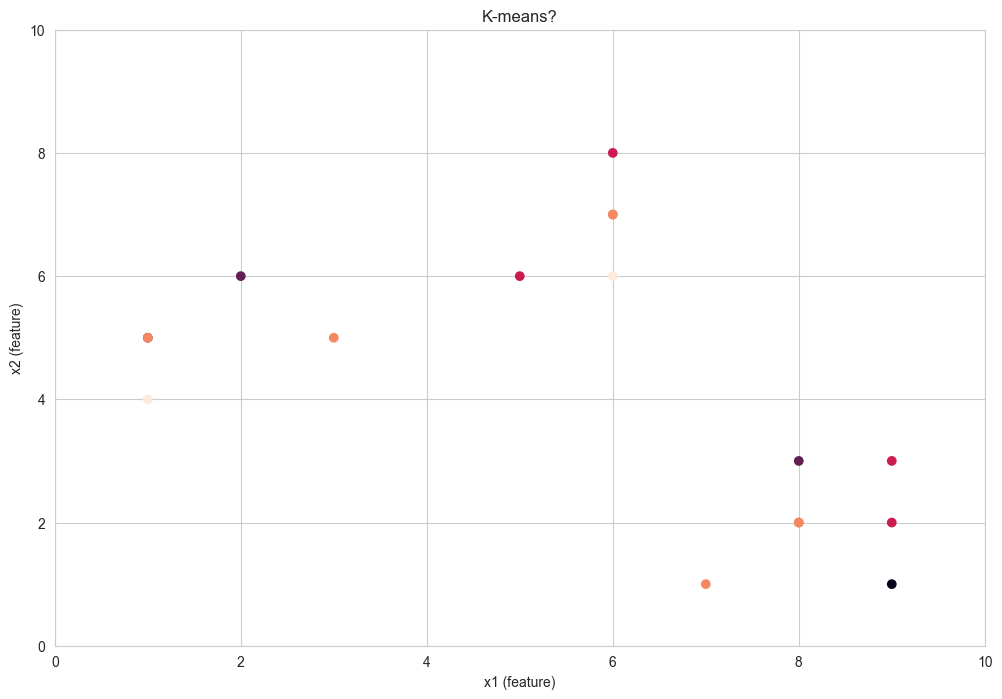

In [41]:
labels = np.random.randint(0, 5, len(y))
plt.scatter(X[:,0], X[:,1], c=labels)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.title("K-means?")
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
print(adjusted_rand_score(labels, y))
print(adjusted_mutual_info_score(labels, y))

In [42]:
print(adjusted_rand_score(~y, y))
print(adjusted_mutual_info_score(~y, y))

1.0
1.0


In [43]:
print(~y, y)

[-1 -1 -1 -1 -1 -2 -2 -2 -2 -2 -3 -3 -3 -3 -3 -3 -3] [0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 2 2]


# 
[DBScan](https://habrahabr.ru/post/322034/)  
[Обзор алгоритмов в sklearn](http://scikit-learn.org/stable/modules/clustering.html)